In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Set the path to your dataset directory
# data_dir = '/content/drive/MyDrive/DL/HW2/flower_photos'

# # Set the path to the directory where you want to store the split data
# split_data_dir = '/content/drive/MyDrive/DL/HW2/split_data'

# # Create directories for train, validation, and test sets
# os.makedirs(os.path.join(split_data_dir, 'train'), exist_ok=True)
# os.makedirs(os.path.join(split_data_dir, 'val'), exist_ok=True)
# os.makedirs(os.path.join(split_data_dir, 'test'), exist_ok=True)

# # Iterate over each flower category
# for category in ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']:
#     category_dir = os.path.join(data_dir, category)

#     # Get the list of image filenames in the category directory
#     image_files = os.listdir(category_dir)

#     # Split the image filenames into train, validation, and test sets
#     train_files, val_test_files = train_test_split(image_files, test_size=0.3, random_state=42)
#     val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=42)

#     # Copy the image files to the respective split directories
#     for split_dir, split_files in [('train', train_files), ('val', val_files), ('test', test_files)]:
#         for file in split_files:
#             src_path = os.path.join(category_dir, file)
#             dst_path = os.path.join(split_data_dir, split_dir, category, file)
#             os.makedirs(os.path.dirname(dst_path), exist_ok=True)
#             shutil.copy(src_path, dst_path)

In [ ]:
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split

# Set the path to your split dataset directory
split_data_dir = '/content/drive/MyDrive/DL/HW2/split_data'

target_size = (224, 224)

# Set the batch size
batch_size = 32

# Create a dataset for the training set
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_data_dir, 'train'),
    image_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    label_mode='categorical'
)

# Create a dataset for the validation set
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_data_dir, 'val'),
    image_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

# Create a dataset for the test set
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(split_data_dir, 'test'),
    image_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

# Apply data preprocessing
rescale_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (rescale_layer(x), y))
val_data = val_data.map(lambda x, y: (rescale_layer(x), y))
test_data = test_data.map(lambda x, y: (rescale_layer(x), y))

Found 2567 files belonging to 5 classes.
Found 551 files belonging to 5 classes.
Found 552 files belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

epochs = 50
history = model.fit(train_data.map(lambda x, y: (data_augmentation(x), y)),
          validation_data=val_data, epochs=epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

18/18 [==============================] - 1s 60ms/step - loss: 0.8399 - accuracy: 0.7192
Test accuracy: 0.7192
18/18 [==============================] - 1s 55ms/step
[[ 72  10   5   6   2]
 [  9 101   4  21   0]
 [  9   5  65   5  13]
 [  0   8   1  95   1]
 [  6   4  30  16  64]]


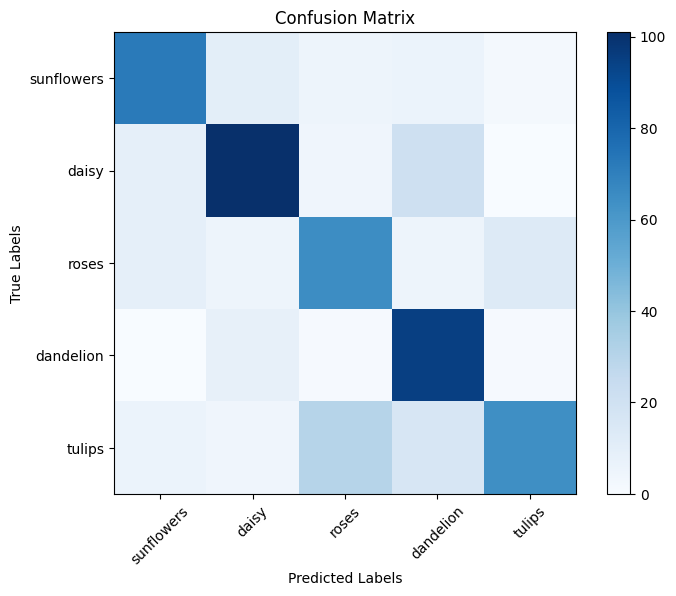

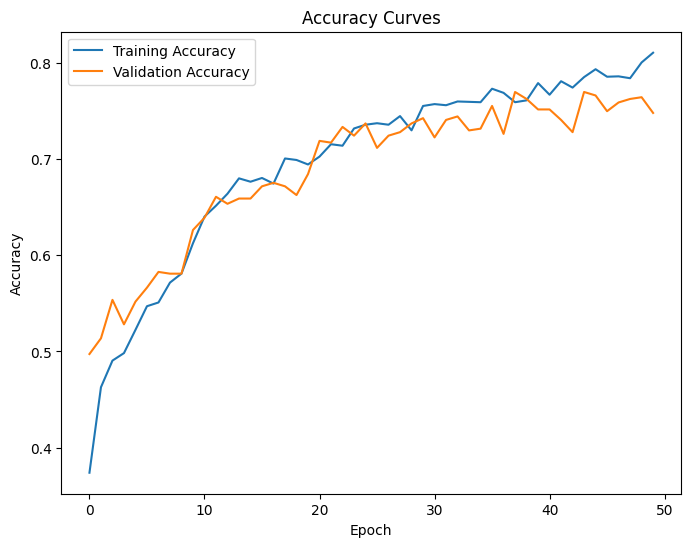

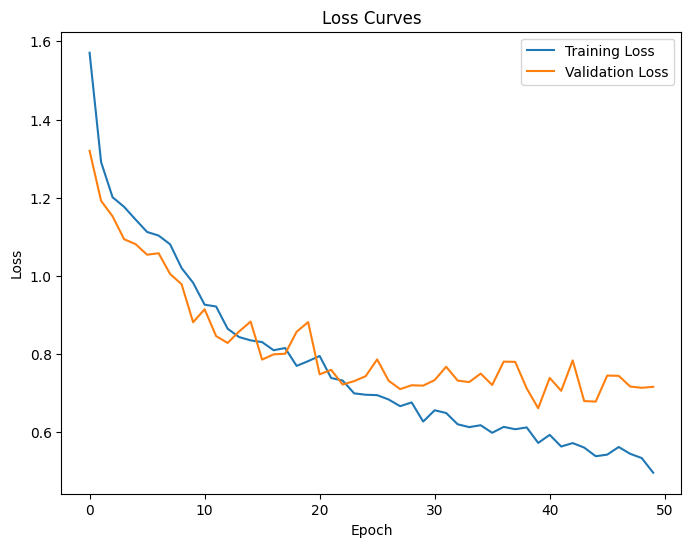

In [ ]:
import numpy as np

class_names = ['sunflowers', 'daisy', 'roses', 'dandelion', 'tulips']

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}')

# Make predictions on the test data
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the test data
y_true = []
for _, labels in test_data:
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

# Convert predicted labels to numpy array
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Set the number of classes
num_classes = 5

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Train the model
epochs = 50
model.fit(train_data.map(lambda x, y: (data_augmentation(x), y)),
          validation_data=val_data, epochs=epochs)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}')



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                 

18/18 [==============================] - 1s 55ms/step - loss: 1.4092 - accuracy: 0.6920
Test accuracy: 0.6920
18/18 [==============================] - 1s 52ms/step
[[71  7  4  5  8]
 [ 8 99  4  8 16]
 [ 7  5 40  6 39]
 [ 1 14  0 81  9]
 [ 5  1 16  7 91]]


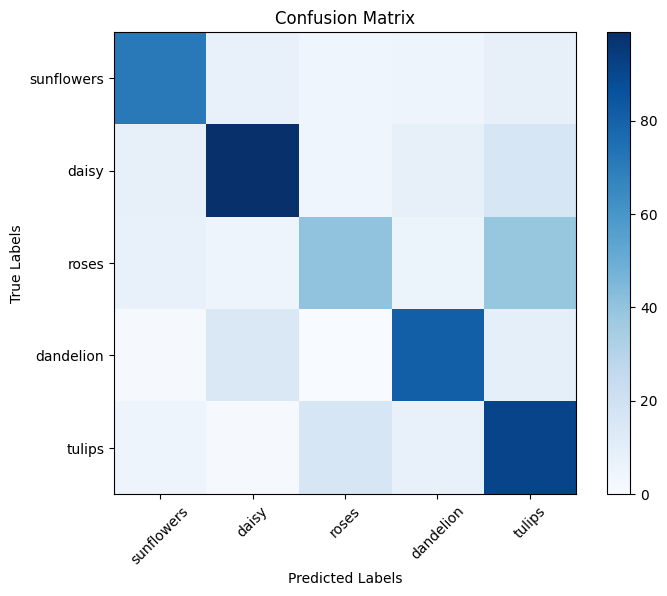

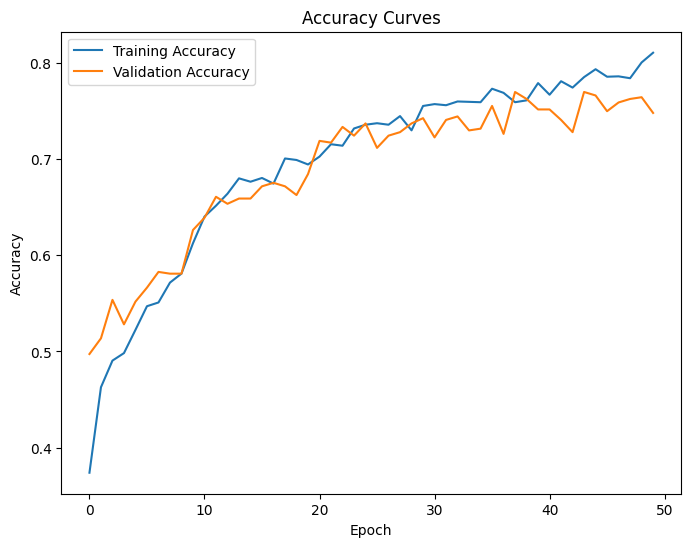

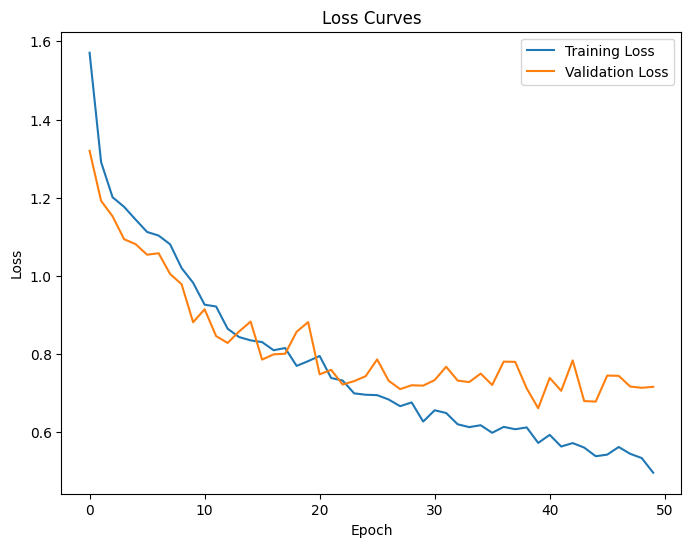

In [ ]:
import numpy as np

class_names = ['sunflowers', 'daisy', 'roses', 'dandelion', 'tulips']

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}')

# Make predictions on the test data
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the test data
y_true = []
for _, labels in test_data:
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

# Convert predicted labels to numpy array
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU

# Set the number of classes
num_classes = 5

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.5), input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.5)),
    Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.5)),
    Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation=LeakyReLU(alpha=0.5)),
    Dense(num_classes, activation='softmax')  # Assuming num_classes is defined elsewhere
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Train the model
epochs = 50
model.fit(train_data.map(lambda x, y: (data_augmentation(x), y)),
          validation_data=val_data, epochs=epochs)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                 

18/18 [==============================] - 1s 56ms/step - loss: 1.4959 - accuracy: 0.6975
Test accuracy: 0.6975
18/18 [==============================] - 2s 55ms/step
[[77  7  3  6  2]
 [19 90  9 15  2]
 [ 8  5 56  7 21]
 [ 4  6  2 89  4]
 [12  7 16 12 73]]


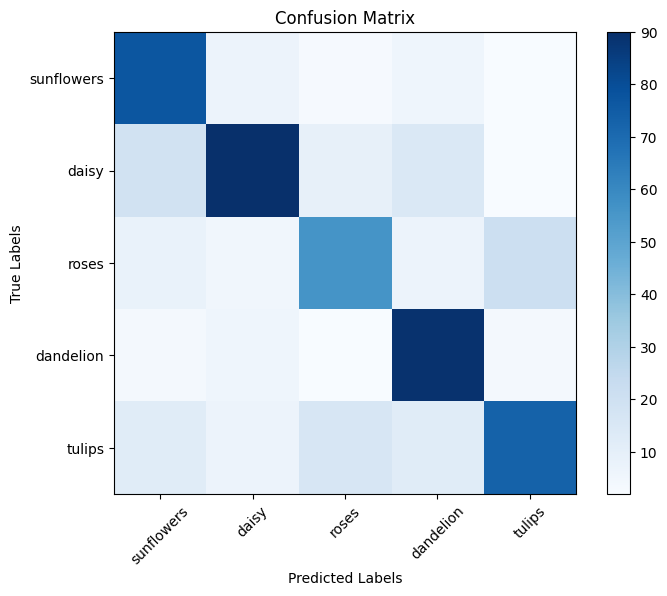

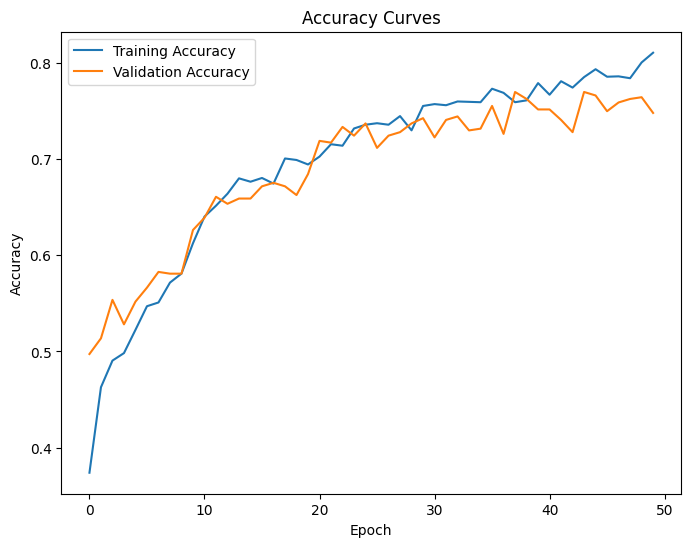

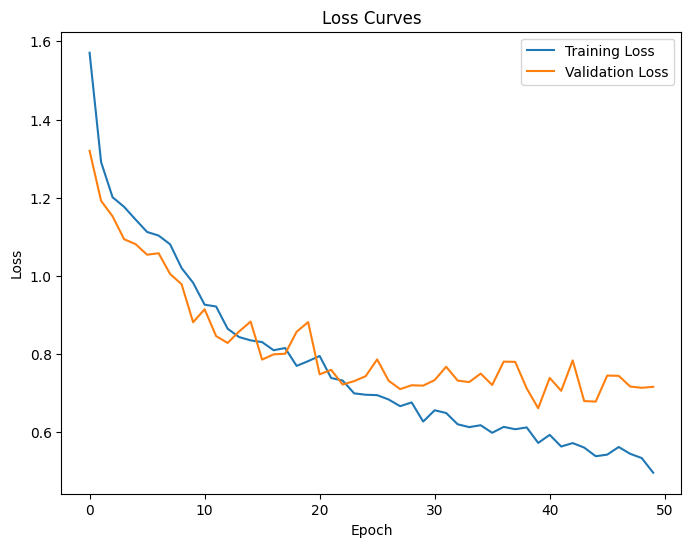

In [ ]:
import numpy as np

class_names = ['sunflowers', 'daisy', 'roses', 'dandelion', 'tulips']

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}')

# Make predictions on the test data
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels from the test data
y_true = []
for _, labels in test_data:
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

# Convert predicted labels to numpy array
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

# Set the number of classes
num_classes = 5

# Define the model architecture
model = Sequential([
    Conv2D(32, (5, 5), activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    Conv2D(512, (3, 3), activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(512, activation=LeakyReLU(alpha=0.3), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Train the model
epochs = 50
model.fit(train_data.map(lambda x, y: (data_augmentation(x), y)), validation_data=val_data, epochs=epochs)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 conv2d_36 (Conv2D)          (None, 218, 218, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 109, 109, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 107, 107, 128)     73856     
                                                                 
 conv2d_38 (Conv2D)          (None, 105, 105, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 52, 52, 128)       0         
 ng2D)                                               

ResourceExhaustedError: Graph execution error:

Detected at node Adam/StatefulPartitionedCall_14 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-12-47134d73f13b>", line 45, in <cell line: 45>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1340, in apply_grad_to_update_var

Out of memory while trying to allocate 2218786948 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    4.13GiB
              constant allocation:         8B
        maybe_live_out allocation:    3.10GiB
     preallocated temp allocation:    2.07GiB
  preallocated temp fragmentation:       124B (0.00%)
                 total allocation:    6.20GiB
Peak buffers:
	Buffer 1:
		Size: 1.03GiB
		XLA Label: fusion
		Shape: f32[270848,1024]
		==========================

	Buffer 2:
		Size: 1.03GiB
		XLA Label: fusion
		Shape: f32[270848,1024]
		==========================

	Buffer 3:
		Size: 1.03GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[270848,1024]
		==========================

	Buffer 4:
		Size: 1.03GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[270848,1024]
		==========================

	Buffer 5:
		Size: 1.03GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[270848,1024]
		==========================

	Buffer 6:
		Size: 1.03GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[270848,1024]
		==========================

	Buffer 7:
		Size: 24B
		Operator: op_type="AssignSubVariableOp" op_name="AssignSubVariableOp" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: (f32[270848,1024], f32[270848,1024], f32[270848,1024])
		==========================

	Buffer 8:
		Size: 8B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: s64[]
		==========================

	Buffer 9:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.4"
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 10:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.4"
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 11:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: constant
		Shape: f32[]
		==========================

	Buffer 12:
		Size: 4B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[]
		==========================

	Buffer 13:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: constant
		Shape: f32[]
		==========================


	 [[{{node Adam/StatefulPartitionedCall_14}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_42978]

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# # Detect hardware and set appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
#     print("Running on TPU:", tpu.master())
# except ValueError:
#     try:
#         gpus = tf.config.experimental.list_logical_devices("GPU")
#         strategy = tf.distribute.MirroredStrategy(gpus)
#         print("Running on GPU:", gpus)
#     except ValueError:
#         strategy = tf.distribute.get_strategy()
#         print("Running on CPU")

# # Set the number of classes
# num_classes = 5

# # Create the ResNet model inside the distribution strategy scope
# with strategy.scope():
#     # Load the pre-trained ResNet50 model
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#     # Unfreeze the top layers of the base model
#     for layer in base_model.layers[-10:]:
#         layer.trainable = True

#     # Create a new model on top of the base model
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dense(512, activation='relu')(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=outputs)

#     # Compile the model
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()

# # Train the model
# epochs = 30
# model.fit(train_data, validation_data=val_data, epochs=epochs)

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_data)
# print(f'Test accuracy: {test_acc:.4f}')

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.regularizers import l2

# # Detect hardware and set appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
#     print("Running on TPU:", tpu.master())
# except ValueError:
#     try:
#         gpus = tf.config.experimental.list_logical_devices("GPU")
#         strategy = tf.distribute.MirroredStrategy(gpus)
#         print("Running on GPU:", gpus)
#     except ValueError:
#         strategy = tf.distribute.get_strategy()
#         print("Running on CPU")

# # Set the number of classes
# num_classes = 5

# # Create the ResNet model inside the distribution strategy scope
# with strategy.scope():
#     # Load the pre-trained ResNet50 model
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#     # Unfreeze the top layers of the base model
#     for layer in base_model.layers[-10:]:
#         layer.trainable = True

#     # Create a new model on top of the base model
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=outputs)

#     # Compile the model
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()

# # Apply data augmentation
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
# ])

# # Train the model with data augmentation
# epochs = 30
# model.fit(train_data.map(lambda x, y: (data_augmentation(x), y)),
#           validation_data=val_data, epochs=epochs)

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_data)
# print(f'Test accuracy: {test_acc:.4f}')